In [1]:
# Importing the packages
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
%matplotlib inline

Client requirement is to build a model to **predict rider retention**.  customer is considered as retained if they are active in 6th month. I included here target variable as longterm_user and set that to 1 if customer is active in 6th month.
</br>

In [2]:
#Read and validate the previously cleaned file
df = pd.read_csv('ultimate_data_challenge_clean.csv')
df.head()


,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,longterm_user
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,0
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,1
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,0


In [3]:
df1 = pd.DataFrame(df)

In [4]:
df.shape

(48581, 13)

We will **convert the object and Boolean type to numerical** so we can run the distance base classifier as SVM, KNN. I will use 70% of data for training and 30% data for testing.

In [5]:
# Create a set of dummy variables from the phone & city variable
df_dummy = pd.get_dummies(df[['phone','city']])
df_dummy = df_dummy.drop(['phone_Android', 'city_Winterfell'], axis=1)
df_dummy.head()

,phone_iPhone,city_Astapor,city_King's Landing
0,1,0,1
1,0,1,0
2,1,1,0
3,1,0,1
4,0,0,0


In [6]:
df =pd.concat([df,df_dummy], axis=1)
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,longterm_user,phone_iPhone,city_Astapor,city_King's Landing
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,0,1,0,1
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,0,0,1,0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,0,1,1,0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,1,1,0,1
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,0,0,0,0


In [7]:
df['ultimate_black_user_n'] = df.ultimate_black_user.map({True:1, False:0})

In [8]:
df = df.drop(['city', 'phone','ultimate_black_user'], axis=1)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48581 entries, 0 to 48580
Data columns (total 14 columns):
avg_dist                  48581 non-null float64
avg_rating_by_driver      48581 non-null float64
avg_rating_of_driver      48581 non-null float64
avg_surge                 48581 non-null float64
last_trip_date            48581 non-null object
signup_date               48581 non-null object
surge_pct                 48581 non-null float64
trips_in_first_30_days    48581 non-null int64
weekday_pct               48581 non-null float64
longterm_user             48581 non-null int64
phone_iPhone              48581 non-null uint8
city_Astapor              48581 non-null uint8
city_King's Landing       48581 non-null uint8
ultimate_black_user_n     48581 non-null int64
dtypes: float64(6), int64(3), object(2), uint8(3)
memory usage: 4.2+ MB


In [10]:
#df = df.drop(['city', 'phone','ultimate_black_user'], axis=1)

In [11]:
df.shape

(48581, 14)

In [12]:
# Prepare the data for modelling
X = pd.DataFrame(df.columns)
X = df[df.columns]
y =df['longterm_user']
X.shape , y.shape

((48581, 14), (48581,))

In [13]:
X['last_trip_date'] = pd.to_datetime(X['last_trip_date'])
X['last_trip_day'] = X['last_trip_date'].dt.day
X['last_trip_month'] = X['last_trip_date'].dt.month

In [14]:
X.shape

(48581, 16)

In [15]:
# dropped signup_date because it is same month data
X = X.drop(['longterm_user','signup_date', 'last_trip_date'], axis=1) 

In [16]:
X.shape

(48581, 13)

In [17]:
# train test split     
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((34006, 13), (14575, 13), (34006,), (14575,))

Our data is ready to use now. It's time now to train the default classifiers with 70% of the data. Since we have **unbalanced class(23% Yes**), we will choose **Auc score and Precision, recall score** as validation criteria.

In [18]:
# KNN Classifier
steps = [('scaler', StandardScaler()),
         ('knn', KNeighborsClassifier(n_jobs=-1))]
#Create the pipeline: pipeline 
pipeline_knn = Pipeline(steps)

# Fit to the training set
pipeline_knn.fit(X_train, y_train)
pipeline_knn_auc = cross_val_score(pipeline_knn , X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)
print(pipeline_knn_auc)
print(pipeline_knn_auc.mean())
knn_prediction = pipeline_knn.predict( X_test )

# get the classification report
knn_report = classification_report( y_test, knn_prediction )
#print the report
print(knn_report)


[ 0.92756385  0.92492564  0.91754604  0.91607346  0.91753452]
0.920728703751
             precision    recall  f1-score   support

          0       0.92      0.91      0.91     10952
          1       0.73      0.75      0.74      3623

avg / total       0.87      0.87      0.87     14575



In [19]:
# Train default LogisticRegression 
steps = [('scaler', StandardScaler()),
         ('logreg', LogisticRegression())]
#Create the pipeline: pipeline 
pipeline_logreg = Pipeline(steps)

# Fit to the training set
pipeline_logreg.fit(X_train, y_train)
pipeline_logreg_auc = cross_val_score(pipeline_logreg , X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)
print(pipeline_logreg_auc)
print(pipeline_logreg_auc.mean())
logreg_prediction = pipeline_logreg.predict( X_test )
# get the classification report
logreg_report = classification_report(y_test, logreg_prediction )
#print the report
print(logreg_report)

[ 0.97718468  0.97391888  0.97213899  0.97383043  0.97408247]
0.974231090133
             precision    recall  f1-score   support

          0       0.96      0.94      0.95     10952
          1       0.82      0.87      0.84      3623

avg / total       0.92      0.92      0.92     14575



In [20]:
rf = RandomForestClassifier(random_state=32)
rf.fit(X_train, y_train)
rf_auc = cross_val_score(rf, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)
print(rf_auc)
print(rf_auc.mean())
rf_prediction = rf.predict( X_test )
# get the classification report
rf_report = classification_report(y_test, rf_prediction )
print(rf_report)

[ 0.96598563  0.96487533  0.96177464  0.9617208   0.95907163]
0.96268560669
             precision    recall  f1-score   support

          0       0.94      0.94      0.94     10952
          1       0.82      0.80      0.81      3623

avg / total       0.91      0.91      0.91     14575



In [21]:
# Train default LinearSV 
steps = [('scaler', StandardScaler()),
         ('svclinear', svm.LinearSVC())]
#Create the pipeline: pipeline 
pipeline_svclinear = Pipeline(steps)

# Fit to the training set
pipeline_svclinear.fit(X_train, y_train)
svclin = cross_val_score(pipeline_svclinear, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)
print(svclin)
print(svclin.mean())
svclinear_prediction = pipeline_svclinear.predict( X_test )
# get the classification report
svclinear_report = classification_report( y_test, svclinear_prediction )
#print the report
print(svclinear_report)

[ 0.97718028  0.97400421  0.97207728  0.97398024  0.97413619]
0.974275640117
             precision    recall  f1-score   support

          0       0.96      0.94      0.95     10952
          1       0.82      0.87      0.84      3623

avg / total       0.92      0.92      0.92     14575



In [22]:
# SVC Model
steps = [('scaler', StandardScaler()),
         ('svc', svm.SVC(probability=True))]
#Create the pipeline: pipeline 
pipeline_svc = Pipeline(steps)

# Fit to the training set
pipeline_svc.fit(X_train, y_train)
svc_auc = cross_val_score(pipeline_svc, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)
print(svc_auc)
print(svc_auc.mean())
svc_prediction = pipeline_svc.predict( X_test )
# get the classification report
svc_report = classification_report( y_test, svc_prediction )
#print the report
print(svc_report)

[ 0.97282053  0.96912854  0.96746292  0.96851112  0.96750286]
0.969085194232
             precision    recall  f1-score   support

          0       0.96      0.93      0.94     10952
          1       0.81      0.88      0.84      3623

avg / total       0.92      0.92      0.92     14575



In [23]:
# Train default GBMode
gbmodel= GradientBoostingClassifier(random_state = 32)
# Fit to the training set
gbmodel.fit(X_train, y_train)
gb_auc = cross_val_score(gbmodel, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)
print(gb_auc)
print(gb_auc.mean())
gbmodel_prediction = gbmodel.predict( X_test )
# get the classification report
gbmodel_report = classification_report(y_test, gbmodel_prediction )
#print the report
print(gbmodel_report)

[ 0.97712607  0.97424745  0.97197534  0.97383807  0.97350297]
0.974137980817
             precision    recall  f1-score   support

          0       0.95      0.94      0.95     10952
          1       0.82      0.86      0.84      3623

avg / total       0.92      0.92      0.92     14575



In [24]:
feature_import_gbmodel = pd.Series(gbmodel.feature_importances_, index=X_test.columns)
feature_import_gbmodel.sort_values(ascending=False)

last_trip_month           0.417614
last_trip_day             0.179758
avg_dist                  0.104851
trips_in_first_30_days    0.054618
surge_pct                 0.044811
avg_surge                 0.042916
weekday_pct               0.042444
avg_rating_of_driver      0.041975
avg_rating_by_driver      0.032284
city_King's Landing       0.018129
phone_iPhone              0.010880
city_Astapor              0.009720
ultimate_black_user_n     0.000000
dtype: float64

Choose linearsvc or logistic or GradientBoostingClassifier

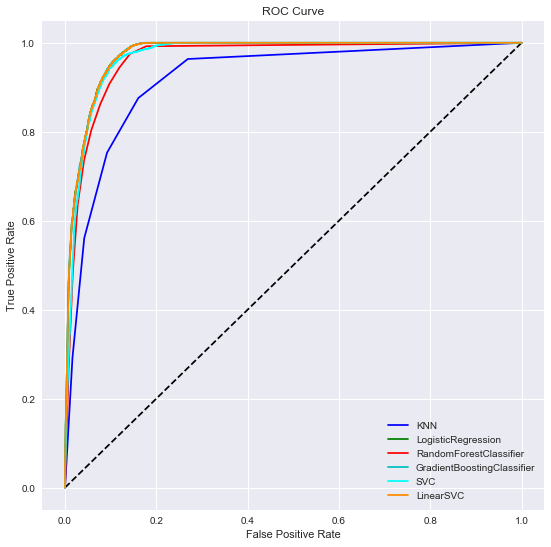

In [25]:
#plot ROC Curves
fig , ax1 = plt.subplots(figsize=(9,9) )
plt.plot([0, 1], [0, 1], 'k--')
estimators =[pipeline_knn, pipeline_logreg, rf, gbmodel, pipeline_svc, pipeline_svclinear]
classifiers=['KNN', 'LogisticRegression', 'RandomForestClassifier','GradientBoostingClassifier','SVC', 'LinearSVC']
colors = ['b', 'g', 'r', 'c','aqua','darkorange']
for i, estimator in enumerate(estimators):
    if (estimator == pipeline_svclinear):
        y_pred_prob = estimator.decision_function(X_test)
    else:
        y_pred_prob = estimator.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds= roc_curve(y_test, y_pred_prob)
    plt.plot(fpr, tpr, label=classifiers[i],color=colors[i])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.title('ROC Curve')

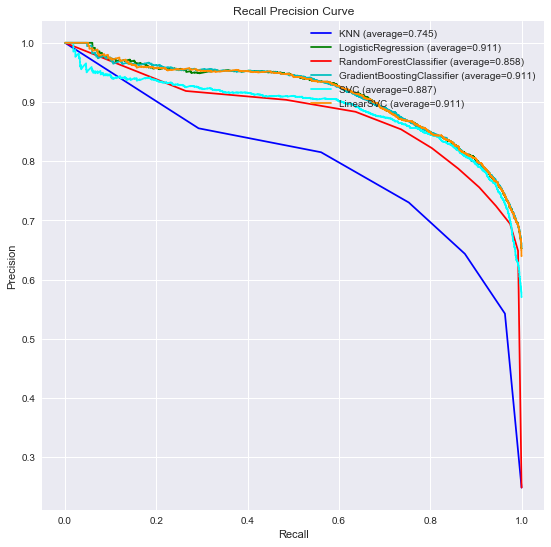

In [26]:
#plot Recall-Precision Curves
fig , ax1 = plt.subplots(figsize=(9,9) )
estimators =[pipeline_knn, pipeline_logreg, rf, gbmodel, pipeline_svc, pipeline_svclinear]
classifiers=['KNN', 'LogisticRegression', 'RandomForestClassifier','GradientBoostingClassifier','SVC', 'LinearSVC']
colors = ['b', 'g', 'r', 'c','aqua','darkorange']
for i, estimator in enumerate(estimators):
    if (estimator == pipeline_svclinear):
        y_pred_prob = estimator.decision_function(X_test)
    else:
        y_pred_prob = estimator.predict_proba(X_test)[:,1]
    precision, recall, _ = precision_recall_curve(y_test,y_pred_prob)
    average_precision= average_precision_score(y_test, y_pred_prob, average="micro")
    plt.plot(recall, precision, label='%s (average=%.3f)'%(classifiers[i],average_precision), color=colors[i])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc=1)
plt.title('Recall Precision Curve')

In [27]:
print('knn_roc_auc_score:',roc_auc_score(y_test, knn_prediction))
print('logreg_roc_auc_score:', roc_auc_score(y_test, logreg_prediction))
print('rf_prediction_roc_auc_score:', roc_auc_score(y_test, rf_prediction))
print('svclinear_prediction_roc_auc_score:', roc_auc_score(y_test, svclinear_prediction))
print('svc_prediction_prediction_roc_auc_score:', roc_auc_score(y_test, svc_prediction))
print('gbmodel_prediction_roc_auc_score:', roc_auc_score(y_test, gbmodel_prediction))

knn_roc_auc_score: 0.830464585181
logreg_roc_auc_score: 0.902169381581
rf_prediction_roc_auc_score: 0.872977020444
svclinear_prediction_roc_auc_score: 0.901846667575
svc_prediction_prediction_roc_auc_score: 0.904903743271
gbmodel_prediction_roc_auc_score: 0.89870351381


As you can see from the above diagrams we have LogisticRegression, GradientBoostingClassifier and  LinearSVC has high precision and recall curve, I chose to tune these classifiers further.

In [28]:
# Tune Logistic Regression
steps = [('scaler', StandardScaler()),
         ('logreg', LogisticRegression())]

pipeline = Pipeline(steps)

param_dist = {"logreg__penalty":['l1','l2'],
              "logreg__C":[.01, .001 , .1, 1, 10, 100]
             }

# Instantiate a Decision Tree classifier: tree
tree = RandomForestClassifier()

# Instantiate the RandomizedSearchCV object: tree_cv
logreg_cv = GridSearchCV(pipeline, param_dist, cv=5, scoring='roc_auc',n_jobs=-1)

# Fit it to the data
logreg_cv.fit(X_train,y_train)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(logreg_cv.best_params_))
print("Best score is {}".format(logreg_cv.best_score_))

Tuned Decision Tree Parameters: {'logreg__C': 0.1, 'logreg__penalty': 'l1'}
Best score is 0.9742702553919479


In [29]:
# Train Tuned LogisticRegression 
steps = [('scaler', StandardScaler()),
         ('logreg', LogisticRegression(C=0.1))]
#Create the pipeline: pipeline 
pipeline_logreg_tuned = Pipeline(steps)

# Fit to the training set
pipeline_logreg_tuned.fit(X_train, y_train)
pipeline_logreg_auc = cross_val_score(pipeline_logreg_tuned , X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)
print(pipeline_logreg_auc)
print(pipeline_logreg_auc.mean())
logreg_prediction = pipeline_logreg_tuned.predict( X_test )
# get the classification report
logreg_report = classification_report(y_test, logreg_prediction )
#print the report
print(logreg_report)

[ 0.97652065  0.97285748  0.97096077  0.97227201  0.97270651]
0.973063481896
             precision    recall  f1-score   support

          0       0.96      0.93      0.95     10952
          1       0.82      0.88      0.84      3623

avg / total       0.92      0.92      0.92     14575



In [30]:
# Tune GradientBoosting Classifier

param_dist = {'learning_rate': [0.1, 0.05, 0.02, 0.01],
               'min_samples_leaf': [5, 20, 50,100,150],
              'n_estimators': [100, 200, 500],
              'subsample':[.5, .8, 1]}

# Instantiate a Decision Tree classifier: tree
gm = GradientBoostingClassifier()

# Instantiate the RandomizedSearchCV object: tree_cv
gm_cv = RandomizedSearchCV(gm, param_dist, cv=5, scoring='roc_auc',n_jobs=-1)

# Fit it to the data
gm_cv.fit(X_train,y_train)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(gm_cv.best_params_))
print("Best score is {}".format(gm_cv.best_score_))

Tuned Decision Tree Parameters: {'subsample': 0.8, 'n_estimators': 500, 'min_samples_leaf': 50, 'learning_rate': 0.01}
Best score is 0.9742887719316395


In [31]:
# Train Tuned GradientBoostingClassifier
gbmodel_tuned= GradientBoostingClassifier(random_state = 32,subsample= 0.8, n_estimators= 500, min_samples_leaf= 5, learning_rate= 0.01)
# Fit to the training set
gbmodel_tuned.fit(X_train, y_train)
gb_auc = cross_val_score(gbmodel_tuned, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)
print(gb_auc)
print(gb_auc.mean())
gbmodel_prediction = gbmodel_tuned.predict( X_test )
# get the classification report
gbmodel_report = classification_report(y_test, gbmodel_prediction )
#print the report
print(gbmodel_report)

[ 0.97727643  0.97417515  0.97204643  0.97394881  0.97382435]
0.974254233881
             precision    recall  f1-score   support

          0       0.95      0.94      0.95     10952
          1       0.82      0.86      0.84      3623

avg / total       0.92      0.92      0.92     14575



In [32]:
# Tune LinearSVC
steps = [('scaler', StandardScaler()),
         ('linearsvc', svm.LinearSVC())]

pipeline = Pipeline(steps)

param_dist = {"linearsvc__class_weight" :[None,'balanced'],
              "linearsvc__C":[.01, .001 , .1, 1, 10, 100]
             }


# Instantiate the RandomizedSearchCV object: tree_cv
linear_cv = GridSearchCV(pipeline, param_dist, cv=5, scoring='roc_auc',n_jobs=-1)

# Fit it to the data
linear_cv.fit(X_train,y_train)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(linear_cv.best_params_))
print("Best score is {}".format(linear_cv.best_score_))

Tuned Decision Tree Parameters: {'linearsvc__C': 1, 'linearsvc__class_weight': None}
Best score is 0.9742761884770381


As we can see above LinearSVC has best result on default parameters. Further tuning is not needed.

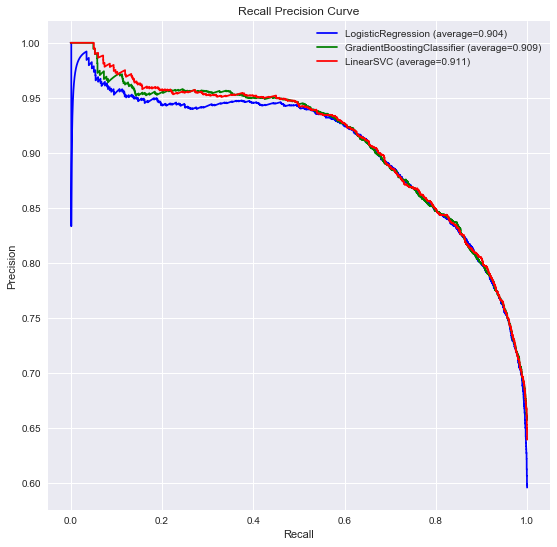

In [33]:
#plot Recall-Precision Curves after tuning
fig , ax1 = plt.subplots(figsize=(9,9) )
estimators =[pipeline_logreg_tuned, gbmodel_tuned, pipeline_svclinear]
classifiers=['LogisticRegression','GradientBoostingClassifier', 'LinearSVC']
colors = ['b', 'g', 'r']
for i, estimator in enumerate(estimators):
    if (estimator == pipeline_svclinear):
        y_pred_prob = estimator.decision_function(X_test)
    else:
        y_pred_prob = estimator.predict_proba(X_test)[:,1]
    precision, recall, _ = precision_recall_curve(y_test,y_pred_prob)
    average_precision= average_precision_score(y_test, y_pred_prob, average="micro")
    plt.plot(recall, precision, label='%s (average=%.3f)'%(classifiers[i],average_precision), color=colors[i])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc=1)
plt.title('Recall Precision Curve')

I would suggest **Linear SVC model** here , because it has both **highest precision(0.82 ) and highest recall(0.87)** score.

# Some Recommendations 

+ Ultimate black users i.e. **people who took ride in 1st 30 days are the potential long term-user**. Bar graph below clearly shows this trend. So, in my opinion **company can encourage customers to take ride within 30 days of singing** by using some reward program or any different marketing strategies.

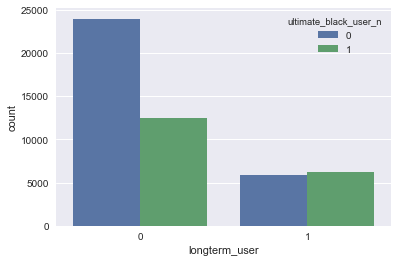

In [34]:
sns.countplot('longterm_user',hue='ultimate_black_user_n', data=df)

+ A customer being long time user **doesn’t depend on what kind of the phone (android or iPhone) customer is using**.  So, they can drop this feature going ahead while collecting the data for prediction purpose.

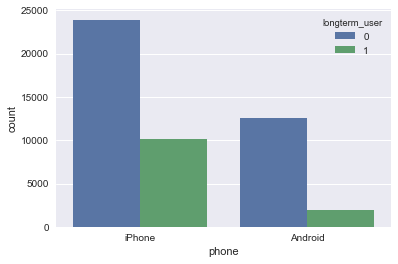

In [35]:
sns.countplot('phone',hue='longterm_user', data=df1)

Most of the **long- term users are from King's Landing city**. Company can prioritize this city to attract more customer.

In [36]:
df1.groupby('city')['longterm_user'].mean().sort_values(ascending=False)

city
King's Landing    0.402622
Winterfell        0.237808
Astapor           0.167912
Name: longterm_user, dtype: float64

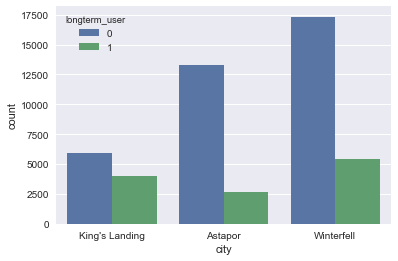

In [37]:
sns.countplot('city',hue='longterm_user', data=df1)